# G3 Cell Counting Analysis

From 27,462 raw images spanning several different treatment conditions (denoted as "colors") as well as flow regimes (aka pumping methods)

### Initialization

In [1]:
data_dir = '/lab/data/celldom/output/20180820-G3-full'
min_cell_size = 15
max_cell_size = 250

In [2]:
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
import celldom
import glob
import plotnine as pn
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from celldom.core import cytometry
from celldom.core import modeling

## EDA

In [19]:
# Open read-only connection to datastore containing result tables
store = cytometry.get_readonly_datastore(data_dir)

In [20]:
cell_data = store.get('table_cell')
len(cell_data)

738623

In [21]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738623 entries, 0 to 14
Data columns (total 25 columns):
acq_apartment       738623 non-null object
acq_cohort          738623 non-null object
acq_color           738623 non-null object
acq_condition       738623 non-null object
acq_datetime        738623 non-null datetime64[ns]
acq_hours           738623 non-null object
acq_id              738623 non-null object
acq_processed_at    738623 non-null datetime64[ns]
acq_pump            738623 non-null object
acq_street          738623 non-null object
apt_id              738623 non-null int64
apt_num             738623 non-null object
area                738623 non-null int64
centroid_x          738623 non-null float64
centroid_y          738623 non-null float64
eccentricity        738623 non-null float64
in_chamber          738623 non-null bool
in_trap             738623 non-null bool
roi_xmax            738623 non-null int64
roi_xmin            738623 non-null int64
roi_ymax            73

In [39]:
g = cell_data.groupby('acq_pump')

In [41]:
len(g.get_group('gravity'))

615549

In [7]:
apt_data = store.get('table_apartment')

In [8]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123019 entries, 0 to 4
Data columns (total 36 columns):
acq_apartment             123019 non-null object
acq_cohort                123019 non-null object
acq_color                 123019 non-null object
acq_condition             123019 non-null object
acq_datetime              123019 non-null datetime64[ns]
acq_hours                 123019 non-null object
acq_id                    123019 non-null object
acq_processed_at          123019 non-null datetime64[ns]
acq_pump                  123019 non-null object
acq_street                123019 non-null object
apt_id                    123019 non-null int64
apt_image_height          123019 non-null int64
apt_image_width           123019 non-null int64
apt_num                   123019 non-null object
apt_num_digit_scores      123019 non-null object
cell_area_mean            113407 non-null float64
cell_area_p10             113407 non-null float64
cell_area_p50             113407 non-null floa

### Growth Rate Modeling

In [137]:
exp_group_cols = ['acq_cohort', 'acq_pump', 'acq_color', 'acq_condition']

df = apt_data.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123019 entries, 0 to 4
Data columns (total 36 columns):
acq_apartment             123019 non-null object
acq_cohort                123019 non-null object
acq_color                 123019 non-null object
acq_condition             123019 non-null object
acq_datetime              123019 non-null datetime64[ns]
acq_hours                 123019 non-null object
acq_id                    123019 non-null object
acq_processed_at          123019 non-null datetime64[ns]
acq_pump                  123019 non-null object
acq_street                123019 non-null object
apt_id                    123019 non-null int64
apt_image_height          123019 non-null int64
apt_image_width           123019 non-null int64
apt_num                   123019 non-null object
apt_num_digit_scores      123019 non-null object
cell_area_mean            113407 non-null float64
cell_area_p10             113407 non-null float64
cell_area_p50             113407 non-null floa

In [138]:
dfdt = df.groupby(exp_group_cols)['acq_datetime'].agg(['min', 'max']).sort_values('min')
dfdt

min  \
acq_cohort acq_pump acq_color acq_condition                       
Control    gravity  Red       3             2018-06-14 23:26:00   
0.1uM      gravity  Orange    1             2018-06-14 23:49:00   
                              3             2018-06-15 00:02:00   
Control    gravity  White     3             2018-06-15 00:24:00   
                    Blue      1             2018-06-17 18:47:00   
                              3             2018-06-17 19:00:00   
                    White     1             2018-06-17 19:18:00   
0.3uM      gravity  Yellow    1             2018-06-17 20:26:00   
                              3             2018-06-17 20:40:00   
                    Green     1             2018-06-17 21:00:00   
                              3             2018-06-17 21:16:00   
0.5uM      gravity  Red       1             2018-06-17 21:52:00   
                              3             2018-06-17 22:07:00   
                    Pink      1             2018-06-17 22:27:00   
                              3             2018-06-17 22:41:00   
Control    Elveflow Red       3             2018-06-27 13:55:00   
0.1uM      Elveflow Orange    1             2018-06-27 14:11:00   
                              3             2018-06-27 14:27:00   

                                                            max  
acq_cohort acq_pump acq_color acq_condition                      
Control    gravity  Red       3             2018-06-17 14:05:00  
0.1uM      gravity  Orange    1             2018-06-21 22:25:00  
                              3             2018-06-21 22:30:00  
Control    gravity  White     3             2018-06-22 18:09:00  
                    Blue      1             2018-06-19 13:43:00  
                              3             2018-06-22 18:16:00  
                    White     1             2018-06-22 18:05:00  
0.3uM      gravity  Yellow    1             2018-06-22 18:40:00  
                              3             2018-06-22 18:47:00  
                    Green     1             2018-06-22 18:27:00  
                              3             2018-06-22 18:32:00  
0.5uM      gravity  Red       1             2018-06-22 19:10:00  
                              3             2018-06-22 19:15:00  
                    Pink      1             2018-06-22 19:00:00  
                              3             2018-06-22 19:05:00  
Control    Elveflow Red       3             2018-07-03 20:18:00  
0.1uM      Elveflow Orange    1             2018-07-05 19:52:00  
                              3             2018-07-02 15:39:00

In [139]:
df.set_index(exp_group_cols).index.to_series().map(dfdt['min']).sample(n=10)

acq_cohort  acq_pump  acq_color  acq_condition
0.5uM       gravity   Red        1               2018-06-17 21:52:00
0.3uM       gravity   Yellow     3               2018-06-17 20:40:00
0.1uM       gravity   Orange     1               2018-06-14 23:49:00
0.5uM       gravity   Pink       3               2018-06-17 22:41:00
Control     gravity   Blue       1               2018-06-17 18:47:00
0.3uM       gravity   Yellow     3               2018-06-17 20:40:00
0.5uM       gravity   Pink       1               2018-06-17 22:27:00
0.1uM       gravity   Orange     3               2018-06-15 00:02:00
Control     Elveflow  Red        3               2018-06-27 13:55:00
            gravity   Blue       1               2018-06-17 18:47:00
dtype: datetime64[ns]

In [140]:
exp_start_dates = df.set_index(exp_group_cols).index.to_series().map(dfdt['min'])
df['elapsed_hours'] = (df['acq_datetime'].values - exp_start_dates.values) / np.timedelta64(1, 'h')

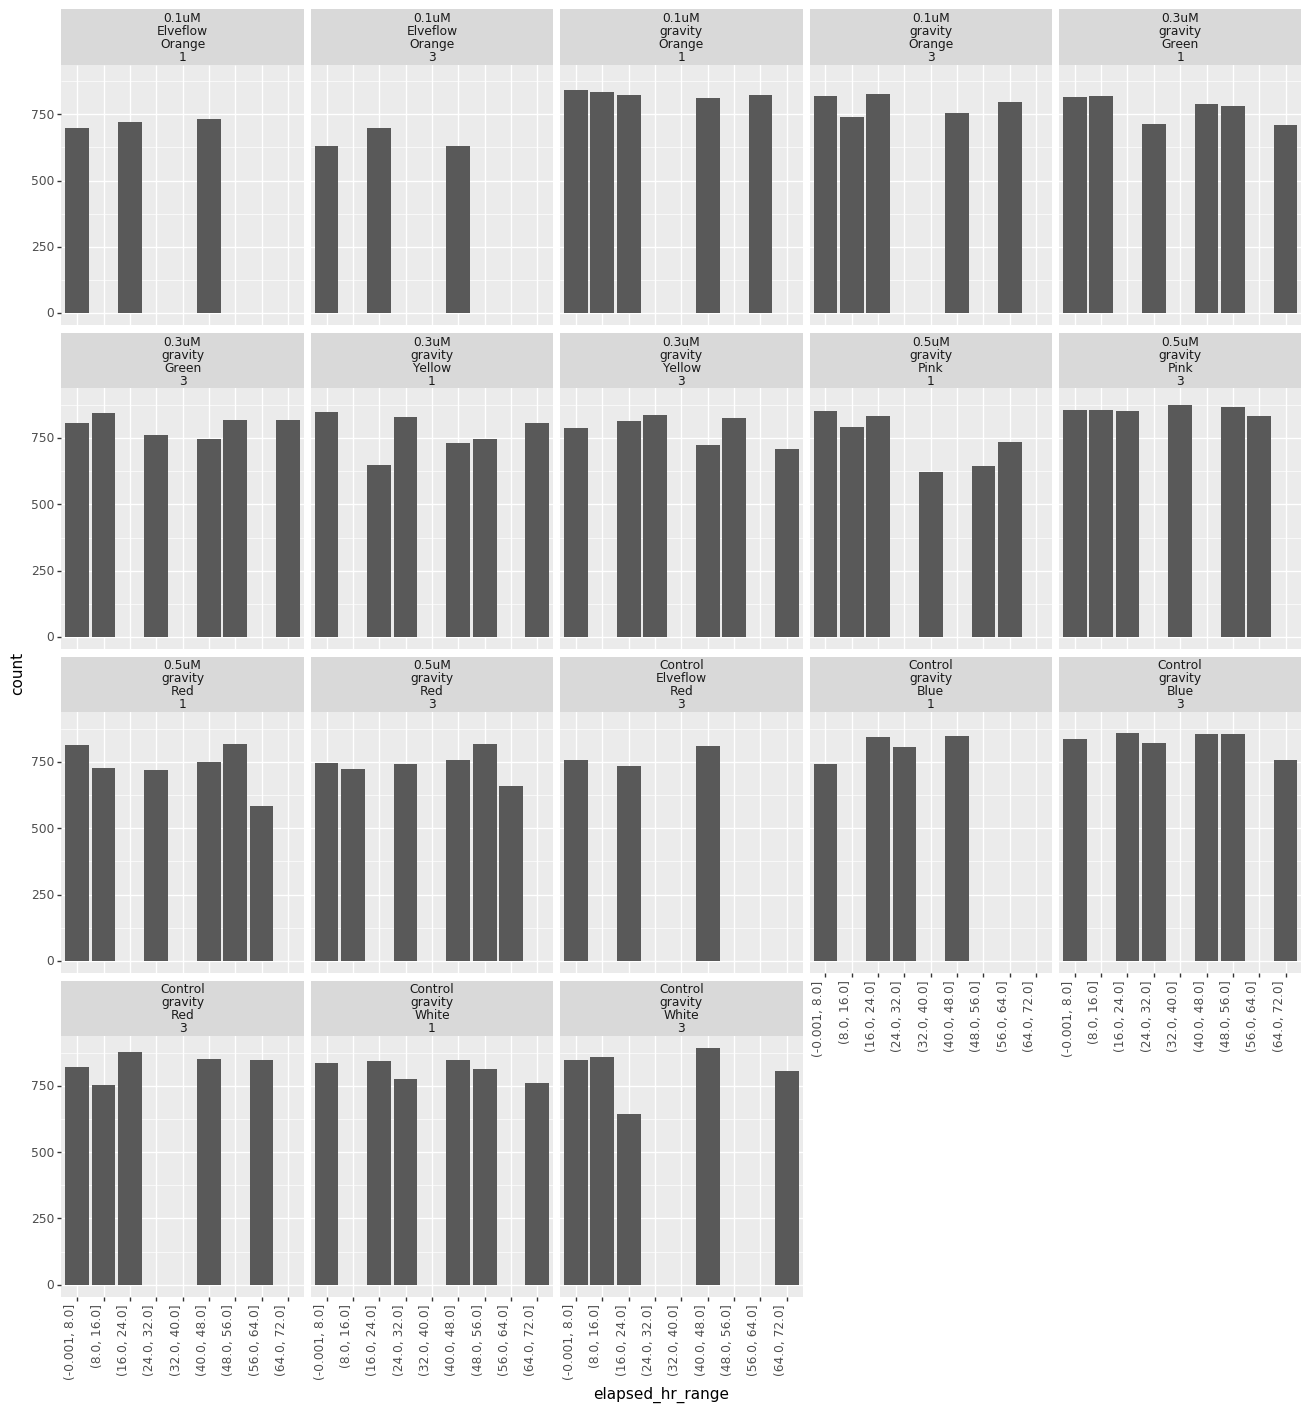

<ggplot: (-9223363271664626211)>

In [141]:
dfp = df.copy()
dfp['elapsed_hr_range'] = pd.cut(df['elapsed_hours'], bins=np.arange(0, 10) * 8, include_lowest=True)
dfp = dfp.groupby(exp_group_cols + ['elapsed_hr_range']).size().rename('count').reset_index()
(
    pn.ggplot(dfp, pn.aes(x='elapsed_hr_range', y='count')) +
    pn.geom_bar(stat='identity') +
    pn.facet_wrap('~' + '+'.join(exp_group_cols)) +
    pn.theme(figure_size=(16, 16), axis_text_x=pn.element_text(rotation=90, hjust=1))
)

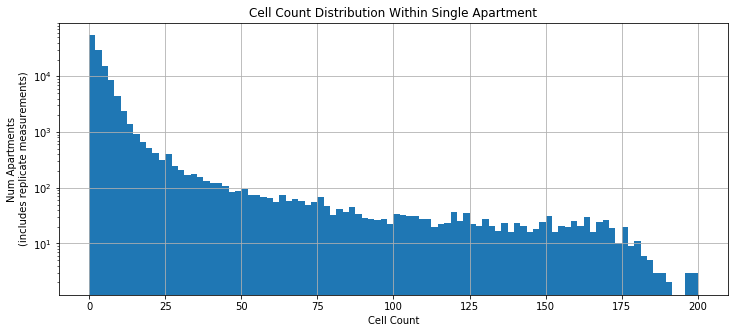

In [142]:
# Sanity check the number of cells inferred within each apartment image
ax = df['cell_count'].hist(bins=96, figsize=(12, 5))
ax.set_yscale('log')
ax.set_title('Cell Count Distribution Within Single Apartment')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Num Apartments\n(includes replicate measurements)')
None

In [143]:
df.groupby(exp_group_cols + ['st_num', 'apt_num', 'elapsed_hours']).size().value_counts()

1    121801
2       556
3        29
4         3
7         1
dtype: int64

In [144]:
# Regroup by apartment + time and compute median cell count across all measurements in time
dfc = df.groupby(exp_group_cols + ['st_num', 'apt_num', 'elapsed_hours'])\
    .agg({'cell_count': 'median'}).reset_index()
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122390 entries, 0 to 122389
Data columns (total 8 columns):
acq_cohort       122390 non-null object
acq_pump         122390 non-null object
acq_color        122390 non-null object
acq_condition    122390 non-null object
st_num           122390 non-null object
apt_num          122390 non-null object
elapsed_hours    122390 non-null float64
cell_count       122390 non-null float64
dtypes: float64(2), object(6)
memory usage: 7.5+ MB


In [18]:
# Compute growth rates
def groupfn(g):
    return pd.Series({
        'growth_rate': modeling.get_growth_rate(g['elapsed_hours'] / 24, g['cell_count']),
        'max_cell_count': g['cell_count'].max(),
        'min_cell_count': g['cell_count'].min(),
        'n_count': len(g),
        'first_count': g.sort_values('elapsed_hours')['cell_count'].iloc[0],
        'elapsed_hours_min': g['elapsed_hours'].min()
    })

dfg = dfc.groupby(exp_group_cols + ['st_num', 'apt_num'])[['elapsed_hours', 'cell_count']].apply(groupfn).reset_index()
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16924 entries, 0 to 16923
Data columns (total 12 columns):
acq_cohort           16924 non-null object
acq_pump             16924 non-null object
acq_color            16924 non-null object
acq_condition        16924 non-null object
st_num               16924 non-null object
apt_num              16924 non-null object
elapsed_hours_min    16924 non-null float64
first_count          16924 non-null float64
growth_rate          16019 non-null float64
max_cell_count       16924 non-null float64
min_cell_count       16924 non-null float64
n_count              16924 non-null float64
dtypes: float64(6), object(6)
memory usage: 1.5+ MB


In [19]:
(dfg['first_count'] < 1).value_counts()

False    15980
True       944
Name: first_count, dtype: int64

In [20]:
(dfg['elapsed_hours_min'] < 1).value_counts()

True     14231
False     2693
Name: elapsed_hours_min, dtype: int64

In [21]:
dfg['n_count'].clip(0, 3).value_counts()

3.0    15611
1.0      905
2.0      408
Name: n_count, dtype: int64

In [22]:
print('Num unique apt+st combinations:', len(dfg[['apt_num', 'st_num']].drop_duplicates()))

Num unique apt+st combinations: 1788


In [23]:
print('Num individual apartments (across all chips):', len(df[exp_group_cols + ['apt_num', 'st_num']].drop_duplicates()))

Num individual apartments (across all chips): 16924


In [24]:
print('Num individual apartments (by chip):')
df.groupby(exp_group_cols).apply(lambda g: len(g[['apt_num', 'st_num']].drop_duplicates()))

Num individual apartments (by chip):


acq_cohort  acq_pump  acq_color  acq_condition
0.1uM       Elveflow  Orange     1                 898
                                 3                 878
            gravity   Orange     1                 922
                                 3                1167
0.3uM       gravity   Green      1                 882
                                 3                 933
                      Yellow     1                 900
                                 3                 886
0.5uM       gravity   Pink       1                 898
                                 3                1099
                      Red        1                 884
                                 3                 887
Control     Elveflow  Red        3                 886
            gravity   Blue       1                 913
                                 3                1012
                      Red        3                 931
                      White      1                 961
                  

In [26]:
(dfg['n_count'] < 2).value_counts(normalize=True)

False    0.946526
True     0.053474
Name: n_count, dtype: float64

In [27]:
dfg['growth_rate'].isnull().value_counts(normalize=True)

False    0.946526
True     0.053474
Name: growth_rate, dtype: float64

## Visualizations

In [77]:
def get_visualization_data():
    dfp = dfg.copy()
    
    # Limit to at least 2 measurements and ensure that first is near start of experiment
    dfp = dfp[dfp['growth_rate'].notnull()]

    dfp = dfp[dfp['elapsed_hours_min'] < 1]
    dfp = dfp[dfp['first_count'] >= 1]

    # Convert st/apt digits to ints
    dfp['st_num'] = dfp['st_num'].astype(int)
    dfp['apt_num'] = dfp['apt_num'].astype(int)

    # Sort categorical values for presentation
    dfp['acq_cohort'] = pd.Categorical(dfp['acq_cohort'], categories=['Control', '0.1uM', '0.3uM', '0.5uM'], ordered=True)
    dfp['acq_color'] = pd.Categorical(dfp['acq_color'], categories=dfp['acq_color'].unique(), ordered=True)

    # Clip to this range, as values outside of it are rare
    dfp['growth_rate'] = dfp['growth_rate'].clip(-.7, 1.5)
    
    return dfp

#### By Treatment

In [121]:
dfp = get_visualization_data()
dfp = dfp[dfp['acq_pump'] == 'gravity']

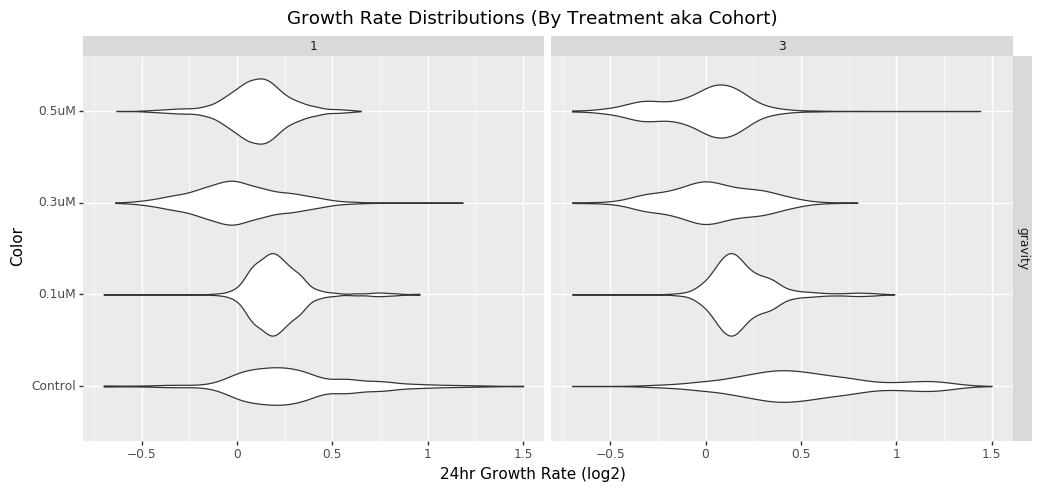

<ggplot: (8765189300060)>

In [122]:
p = (
    pn.ggplot(dfp, pn.aes(x='acq_cohort', y='growth_rate')) +
    pn.geom_violin(alpha=1) + 
    pn.facet_grid('acq_pump ~ acq_condition') +
    pn.theme(figure_size=(12, 5)) + 
    pn.ylab('24hr Growth Rate (log2)') +
    pn.xlab('Color') +
    pn.coord_flip() +
    pn.ggtitle('Growth Rate Distributions (By Treatment aka Cohort)')
)
p

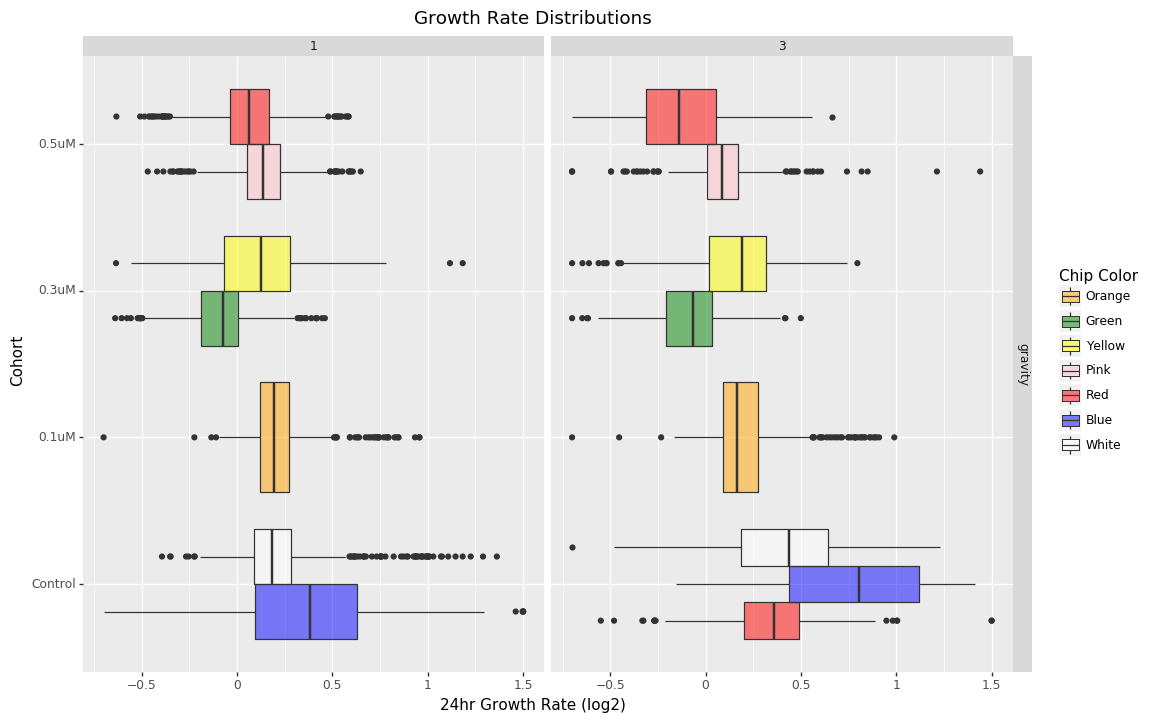

<ggplot: (-9223363271666445659)>

In [123]:
p = (
    pn.ggplot(dfp, pn.aes(x='acq_cohort', y='growth_rate', fill='acq_color')) + 
    pn.geom_boxplot(alpha=.5) +
    pn.facet_grid('acq_pump ~ acq_condition') +
    pn.theme(figure_size=(12, 8)) + 
    pn.scale_fill_manual([c.lower() for c in dfg['acq_color'].unique()], guide=pn.guide_legend(title='Chip Color')) +
    pn.ylab('24hr Growth Rate (log2)') +
    pn.xlab('Cohort') +
    pn.coord_flip() +
    pn.ggtitle('Growth Rate Distributions')
)
p

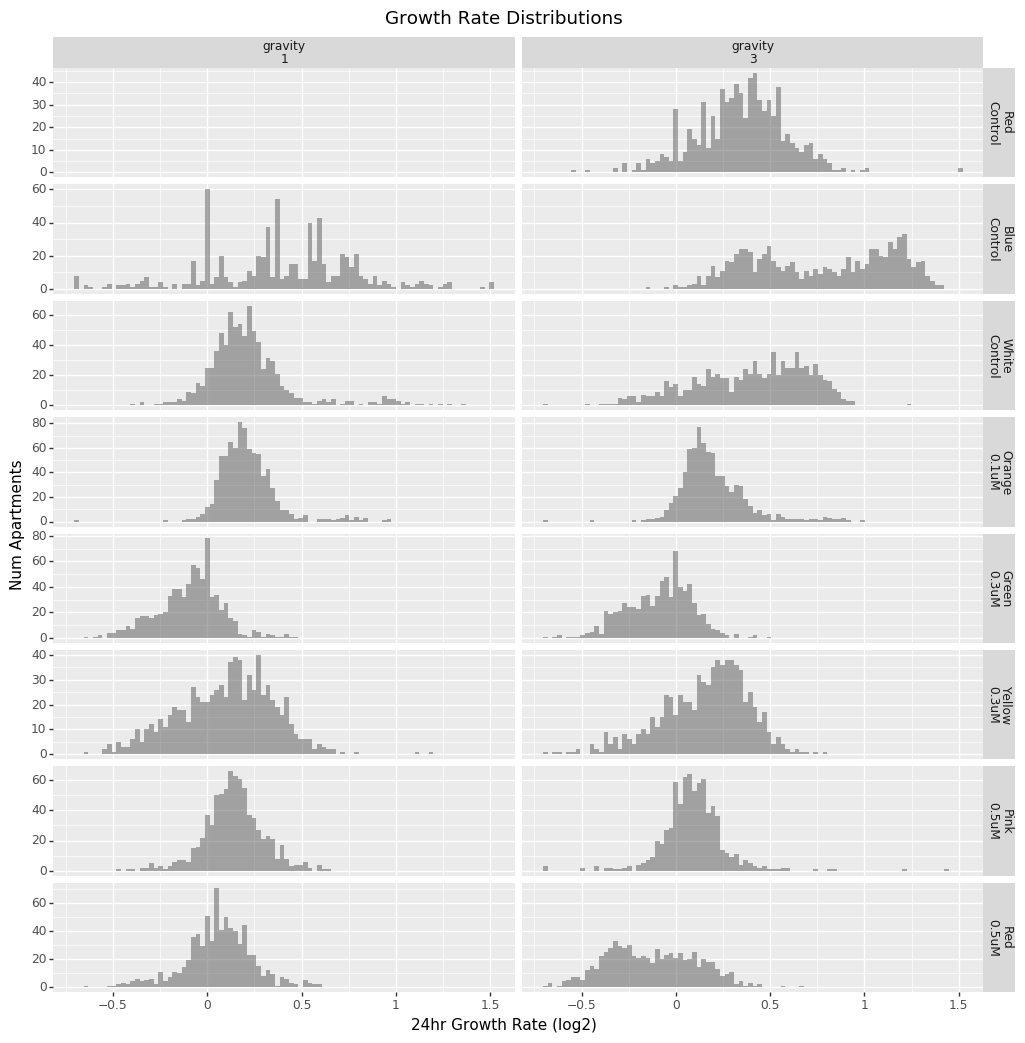

<ggplot: (-9223363271665636534)>

In [81]:
p = (
    pn.ggplot(dfp, pn.aes(x='growth_rate')) +
    pn.geom_histogram(alpha=.5, bins=90) + 
    pn.facet_grid('acq_cohort + acq_color ~ acq_pump + acq_condition', scales='free_y') +
    pn.theme(figure_size=(12, 12)) + 
    pn.xlab('24hr Growth Rate (log2)') +
    pn.ylab('Num Apartments') +
    pn.ggtitle('Growth Rate Distributions')
)
p

### By Flow Regime

In [126]:
dfp = get_visualization_data()
dfp['apt_num_range'] = pd.cut(
    dfp['apt_num'].clip(0, 57), 
    bins=[0, 8, 16, 24, 32, 40, 48, 56, np.inf], 
    labels=['0-7', '8-15', '16-23', '24-31', '32-39', '40-47', '48-55', '56+'],
    include_lowest=True, right=False
)
#dfp['growth_rate'] = dfp['growth_rate'].clip(-.25, 1.)

In [127]:
dfp[dfp['acq_pump'] == 'Elveflow']['acq_color'].unique()

[Orange, Red]
Categories (2, object): [Orange < Red]

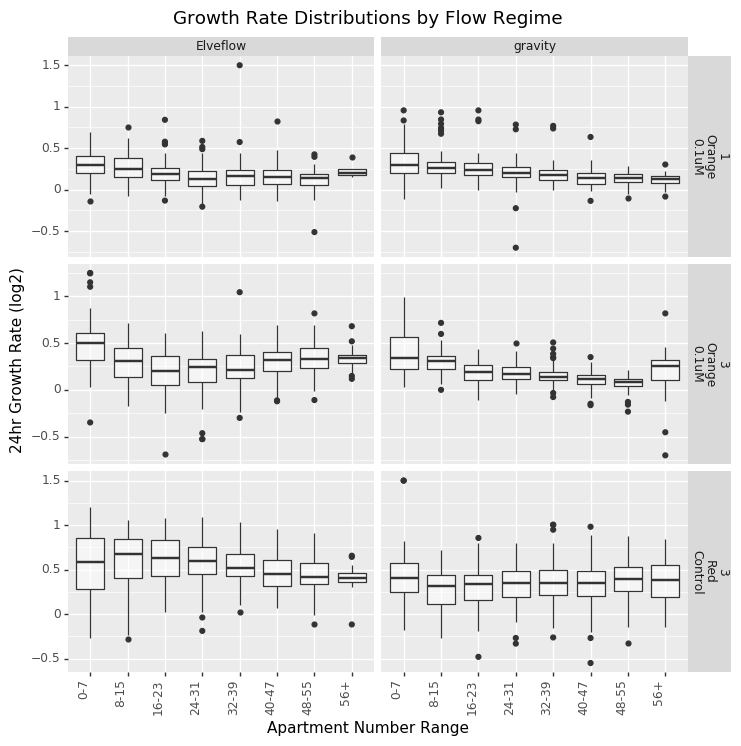

<ggplot: (-9223363271664776027)>

In [94]:
p = (
    pn.ggplot(
        dfp[dfp['acq_color'].isin(['Red', 'Orange']) & dfp['acq_cohort'].isin(['0.1uM', 'Control'])], 
        pn.aes(x='apt_num_range', y='growth_rate')
    ) +
    pn.geom_boxplot(alpha=.5) + 
    pn.facet_grid('acq_cohort + acq_color + acq_condition ~ acq_pump', scales='free_y') +
    pn.xlab('Apartment Number Range') +
    pn.ylab('24hr Growth Rate (log2)') +
    pn.ggtitle('Growth Rate Distributions by Flow Regime') +
    pn.theme(figure_size=(8, 8), axis_text_x=pn.element_text(rotation=90, hjust=1))
)
p

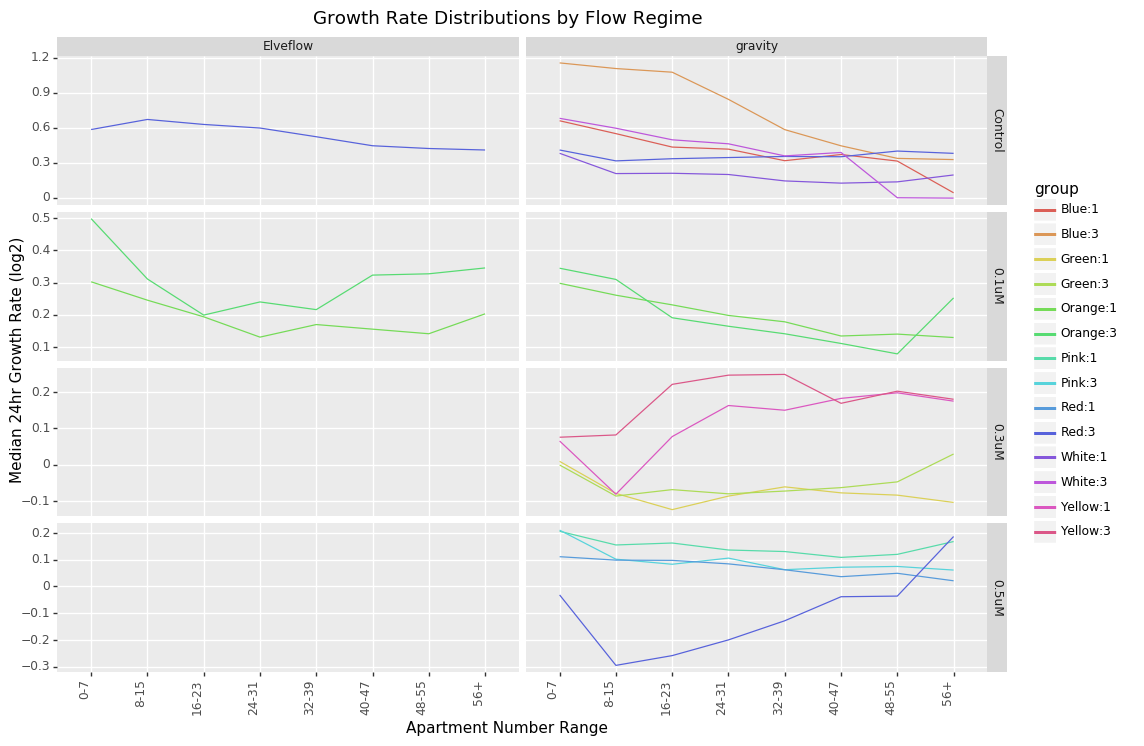

<ggplot: (-9223363271666174569)>

In [133]:

p = (
    pn.ggplot(
        dfp.groupby(exp_group_cols + ['apt_num_range'])['growth_rate'].median().rename('median_growth_rate').reset_index()\
            .pipe(lambda d: d.assign(group=d.apply(lambda r: ':'.join(r[['acq_color', 'acq_condition']]), axis=1))),
        pn.aes(x='apt_num_range', y='median_growth_rate', group='group', color='group')
    ) +
    pn.geom_line(stat='identity') + 
    pn.facet_grid('acq_cohort ~ acq_pump', scales='free_y') +
    pn.xlab('Apartment Number Range') +
    pn.ylab('Median 24hr Growth Rate (log2)') +
    pn.ggtitle('Growth Rate Distributions by Flow Regime') +
    pn.theme(
        figure_size=(12, 8), 
        axis_text_x=pn.element_text(rotation=90, hjust=1),
        panel_grid_minor=pn.element_blank()
    )
)
p